在这个教程中，你将会学到怎么从轨道断面客流数据绘制轨道客流的可视化。Demo:[小旭学长的地铁客流可视化](https://ni1o1.gitee.io/metroflowvisualization/)

<div class="alert alert-info"><h2>提供的基础数据是：</h2><p>

<br>
    GIS文件：<br>
    1.上海轨道2号线-线形<br>
    2.上海轨道2号线-站点<br>
    <br>
    数据：<br>
    1.上海轨道2号线-断面客流（数据纯属虚构，练手用）<br>

</div>

# 读取数据

In [16]:
import geopandas as gpd
shp = r'shapefile\metroline2\metroline2.shp'
line = gpd.GeoDataFrame.from_file(shp,encoding = 'utf-8')
line

,city,linename,geometry
0,上海,地铁2号线(徐泾东-浦东国际机场),LINESTRING (121.2966041058584 31.1912319153729...
1,上海,地铁2号线(浦东国际机场-徐泾东),LINESTRING (121.8024025447652 31.1516215729549...


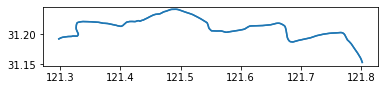

In [57]:
line.plot()

In [48]:
stop = pd.read_csv(r'data-sample\metrostop2.csv')
stop.head(5)

,stationnames,linename,lon,lat
0,徐泾东,地铁2号线(徐泾东-浦东国际机场),121.294879,31.190269
1,虹桥火车站,地铁2号线(徐泾东-浦东国际机场),121.316980,31.195925
2,虹桥2号航站楼,地铁2号线(徐泾东-浦东国际机场),121.321726,31.196596
3,淞虹路,地铁2号线(徐泾东-浦东国际机场),121.354842,31.220001
4,北新泾,地铁2号线(徐泾东-浦东国际机场),121.369405,31.218306


In [38]:
import pandas as pd
data = pd.read_csv(r'data-sample\metrodata-sample.csv',encoding = 'utf-8')
data.head(5)

,FROMSTATIONAME,TOSTATIONAME,FLOW
0,徐泾东,虹桥火车站,1223
1,虹桥火车站,徐泾东,1785
2,虹桥火车站,虹桥2号航站楼,4333
3,虹桥2号航站楼,虹桥火车站,4851
4,虹桥2号航站楼,淞虹路,4105


# 我们想要得到的可视化效果

可视化思路
<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/metro1.png" style="width:500px">


这里我们实现一下左边的思路

# 对一个方向的轨道线进行GIS处理

先取一个方向的轨道线数据

In [120]:
linename = line['linename'].drop_duplicates().iloc[1]
linename

'地铁2号线(浦东国际机场-徐泾东)'

In [109]:
stop_1 = stop[stop['linename'] == linename]
line_1 = line[line['linename'] == linename]

站点的数据还不是geopandas，下面来创建一下geopandas

In [ ]:
###############################你需要在下面写代码##################################
#由stop_1的dataframe，创建geopandas的geodataframe


###################################################################################

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


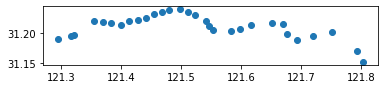

In [110]:
###############################     答    案    ##################################
from shapely.geometry import Point,Polygon
stop_1['geometry'] = stop_1.apply(lambda r:Point(r['lon'],r['lat']),axis = 1)
stop_1 = gpd.GeoDataFrame(stop_1)
###################################################################################
stop_1.plot()

## shapely的简介

在前面，我们已经初步接触过shapely，geopandas是基于shapely的，geodataframe的每个图形，都是一个shapely的geometry。  
同时，geopandas也继承了shapely的一些gis处理方法，但只是**一些**  
结合geopandas自带的一些gis处理功能，和更底层的shapely的gis处理功能，我们可以更自由地在python中完成一些gis操作  
参考资料：  
[shapely包的官方文档](https://shapely.readthedocs.io/en/latest/)  
[geopandas包的官方文档](http://geopandas.org/index.html)

<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/metro2.png" style="width:500px">


In [111]:
#分段并匹配
splited_lines = []
def getclose(lineshp,stop_1):
    lon,lat = lineshp.coords[0]
    stop_1['dis'] = abs(stop_1['lon']-lon)+abs(stop_1['lat']-lat)
    start = stop_1[stop_1['dis'] == stop_1['dis'].min()]['stationnames'].iloc[0]
    lon,lat = lineshp.coords[-1]
    stop_1['dis'] = abs(stop_1['lon']-lon)+abs(stop_1['lat']-lat)
    end = stop_1[stop_1['dis'] == stop_1['dis'].min()]['stationnames'].iloc[0]
    return start,end

from shapely.ops import split, snap
stop_1_geo = stop_1.unary_union
line_1_geo = line_1.unary_union
split_line = split(line_1_geo,stop_1_geo.buffer(0.0008))
splited_line=gpd.GeoDataFrame({'geometry':split_line})
splited_line['linename'] = linename
s = []
e = []
for lineshp in splited_line.geometry:
    start,end = getclose(lineshp,stop_1)
    s.append(start)
    e.append(end)
splited_line['station_a']= s
splited_line['station_b']= e
splited_lines.append(splited_line)

In [112]:
splited_lines = pd.concat(splited_lines)
splited_lines = pd.merge(splited_lines,
    data[['FROMSTATIONAME', 'TOSTATIONAME','FLOW']].rename(columns = {'FROMSTATIONAME':'station_a','TOSTATIONAME':"station_b"}),
         on = ['station_a','station_b'])


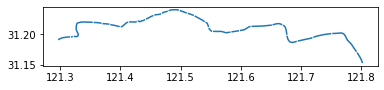

In [113]:
splited_lines.plot()

<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/metro3.png" style="width:500px">


In [115]:
import numpy as np
#生成段
step = 10
splited_lines = splited_lines.sort_values(by = 'FLOW')
splited_lines['linewidth'] = (np.array(range(len(splited_lines)))*step/len(splited_lines)).astype('int')/step+0.1
splited_duans = splited_lines.copy()

geo = []

kuandu = 0.005
for i in range(len(splited_lines)):
    r = splited_lines.iloc[i]
    try:
        ply = Polygon(np.append(np.array(r['geometry'].coords),
    np.array(r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3).coords)).reshape(-1,2))
    except:
        ply = Polygon(np.append(np.array(r['geometry'].coords),
    np.concatenate([np.array(a.coords) for a in r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3)])).reshape(-1,2))
    geo.append(ply)
    
splited_duans['geometry'] = geo

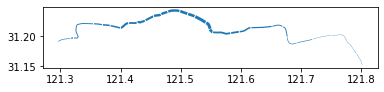

In [119]:
splited_duans.plot()

In [ ]:
splited_duans1 = splited_duans.copy()

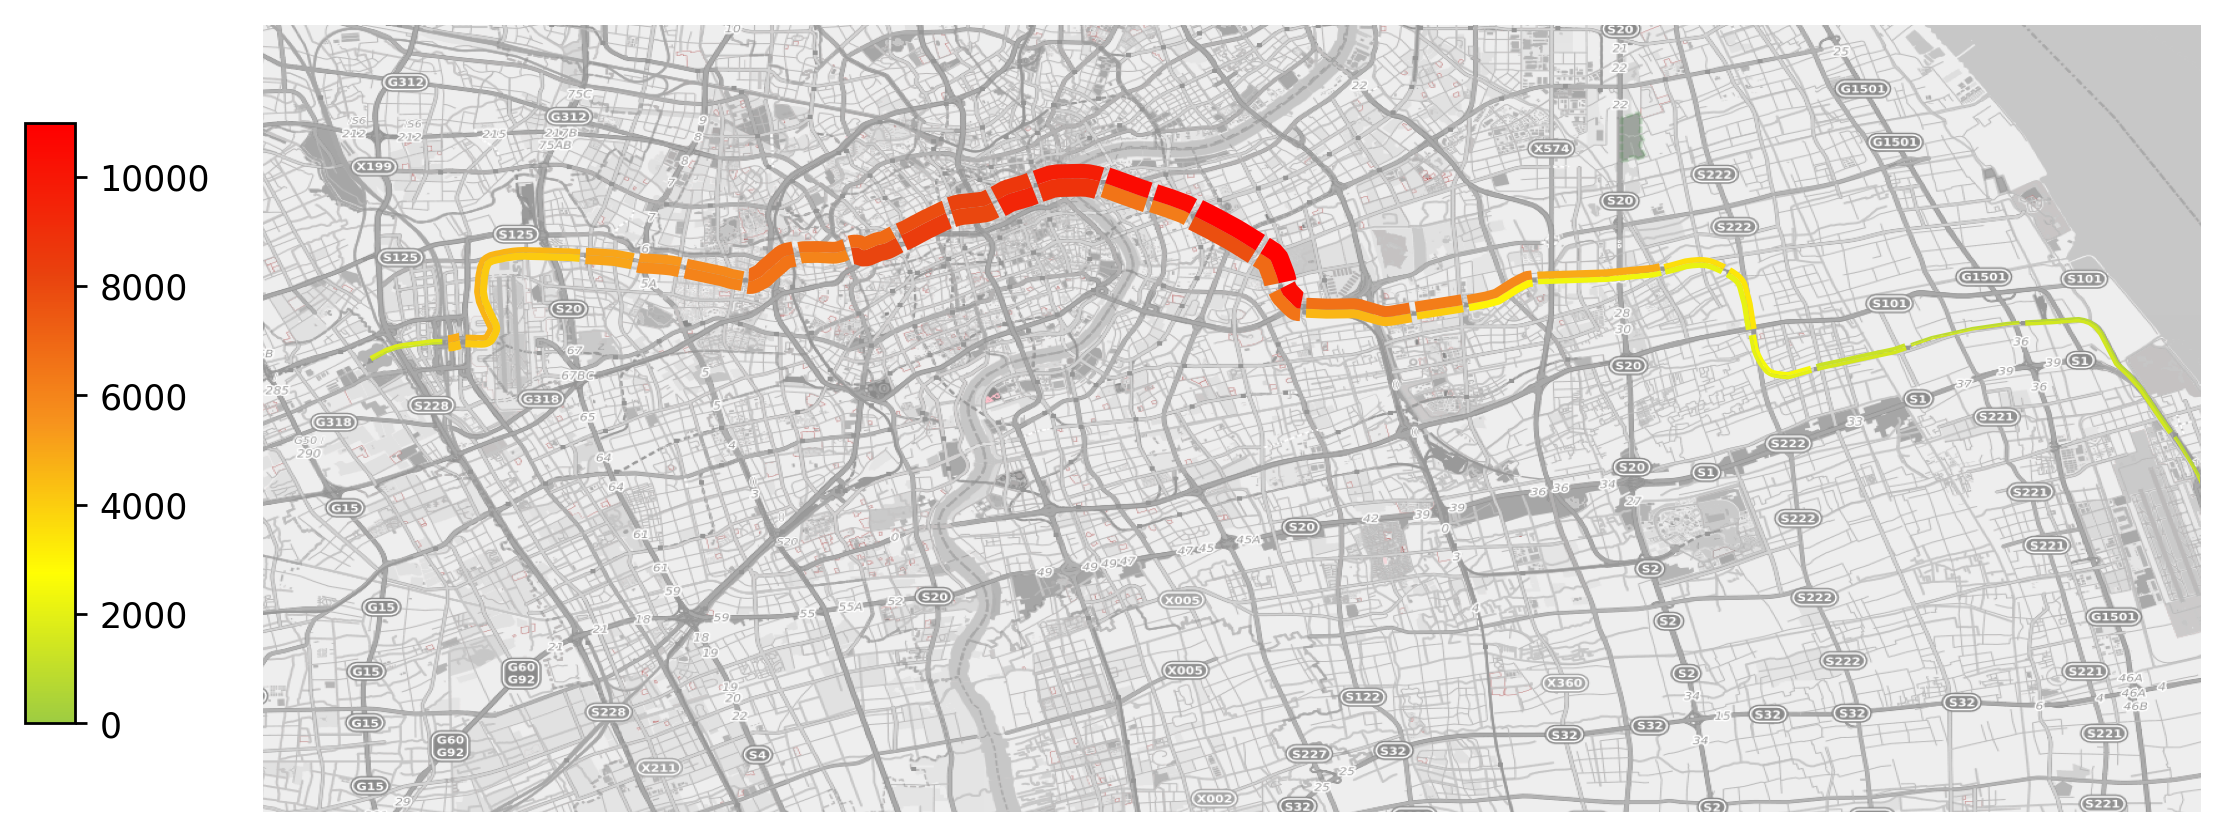

In [118]:

lat1sh = 30.8666667;
lat2sh = 31.5833333;
lon1sh = 121.066667;
lon2sh = 122.0;
bounds = [lon1sh+0.2,lat1sh+0.2,lon2sh-0.2,lat2sh-0.3]

import plot_map
#导入必要的包
import pandas as pd
import numpy as np
#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt
#geopandas包
import geopandas


fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)


cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)
vmax = splited_duans['FLOW'].max()
splited_duans1.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)
splited_duans2.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.03, 0.35, 0.02, 0.3])
plt.colorbar(cax=cax)



plt.show()